In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate
from math import log, sqrt, exp
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import CubicSpline
from pandas import Series,DataFrame
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def SABR_calibration(x, strikes, vols, F, T):
    error = 0.0
    for i, impled_vol in enumerate(vols):
        error += (impled_vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return error

In [3]:
df_alpha = pd.read_csv('SABR_alpha.csv')
df_rho = pd.read_csv('SABR_rho.csv')
df_nu = pd.read_csv('SABR_nu.csv')

df_alpha.index=Series([1,5,10])
df_rho.index=Series([1,5,10])
df_nu.index=Series([1,5,10])

df_alpha.rename(columns={"1Y":1, "2Y":2,"3Y":3,"5Y":5,"10Y":10},inplace=True)
df_rho.rename(columns={"1Y":1, "2Y":2,"3Y":3,"5Y":5,"10Y":10},inplace=True)
df_nu.rename(columns={"1Y":1, "2Y":2,"3Y":3,"5Y":5,"10Y":10},inplace=True)

df_psr = pd.read_csv('oi_libor_disfactors.csv')
df_psr.drop(columns = "Unnamed: 0", inplace=True)

## Question 1: 
### Calculate PV of a leg receiving CMS10y semi-annually over the next 5 years 
### Calculate PV of a leg receiving CMS2y quarterly over the next 10 years

In [4]:
#linear interpolate LIBOR DF based on Time
def LIBORDF(T):
    x = list(df_psr['tenor'])
    y = list(df_psr['d_l'])
    return np.interp(T, x, y)

#linear interpolate OIS DF based on Time
def OISDF(T):
    x = list(df_psr['tenor'])
    y = list(df_psr['d_o'])
    return np.interp(T, x, y)

# using cubic spline to interpolate SABR parameters
def ParameterInterp (expiry, tenor, data):
    splied_from_expiry = []
    for i in [1,2,3,5,10]:
        result = CubicSpline([1, 5, 10], data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(5):
        extract.append(splied_from_expiry[i](expiry))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(tenor))


In [5]:
def Forward_SWAP_RATE(expiry, tenor, delta):   
    month = int(tenor/delta)#number of payment after during tenor period
    float_leg, fixed_leg = 0, 0 #initialize fix and floating leg
    
    for i in range(1,month+1):
        loc = expiry + i*delta
        # float leg = OIS discount factor x forward LIBOR x delta
        float_leg += OISDF(loc)*(1/delta)*((LIBORDF(loc-delta)-LIBORDF(loc))/LIBORDF(loc))*delta

    for i in range(1,month+1):
        # Fixed leg = Sum of OIS discount factor from Expiry to Tenor end
        fixed_leg += OISDF(expiry + i*delta)*delta

    return float_leg/fixed_leg

def Black76Lognormal(F, K, T, r, sigma, opt):
    d1 = (log(F/K)+(sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    if opt == 'Call':
        return F*exp(-r*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    elif opt == 'Put':
        return K*exp(-r*T)*norm.cdf(-d2) - F*exp(-r*T)*norm.cdf(-d1)
    
def IRR(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += Delta*(1 + K* Delta)**(-i)
    return total

def IRR_1st(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(Delta**2)*(1 + K* Delta)**(-i-1)
    return total

def IRR_2nd(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(-i-1)*(Delta**3)*(1 + K* Delta)**(-i-2)
    return total

def h_2nd(Tenor, Delta, K):
    IRR0 = IRR(Tenor, Delta, K)
    IRR1 = IRR_1st(Tenor, Delta, K)
    IRR2 = IRR_2nd(Tenor, Delta, K) 
    return (-IRR2*K - 2*IRR1) / (IRR0**2) + 2*(IRR1**2)*K/(IRR0**3)

def integrand(F, K, T, r, sigma, tenor, delta, opt):
    irr = IRR(tenor, delta, F)
    hppk = h_2nd(tenor, delta, K)
    return hppk*Black76Lognormal(F, K, T, r, sigma, opt)


def CMS(expiry, tenor, delta):
    F       = Forward_SWAP_RATE(expiry, tenor, delta)
    alpha   = ParameterInterp(expiry,tenor,df_alpha)
    rho     = ParameterInterp(expiry,tenor,df_rho)
    nu      = ParameterInterp(expiry,tenor,df_nu)
    VRec     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Put'), 0, F)
    VPay     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Call'), F, 0.1) 
    return F + VRec[0] + VPay[0]

def PV_CMS(tenor, cms_period, delta):
    n = int(cms_period/delta)
    pv = 0
    for i in range(1,n+1):
        loc = i*delta
        pv += OISDF(loc)*delta*CMS(loc,tenor,delta)
    return pv

beta = 0.9

   Unnamed: 0         1         2         3         5        10
1          1Y  0.139070  0.184651  0.196851  0.178052  0.170749
5          5Y  0.166527  0.199497  0.210348  0.191091  0.177421
10        10Y  0.177383  0.195282  0.207103  0.201575  0.181396


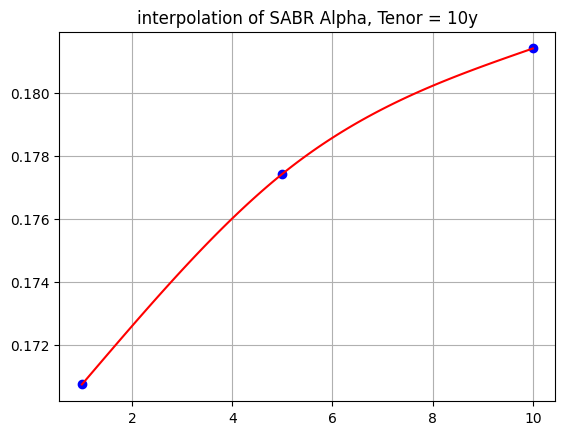

In [6]:
# Cubic Spline Interpolation of alpha
x_range = np.arange(1,10.1,0.1)
print(df_alpha)
plt.plot(df_alpha.index,df_alpha[10],"ob")
plt.plot(x_range, [ParameterInterp(x, 10, df_alpha) for x in x_range],'-r')
plt.title("interpolation of SABR Alpha, Tenor = 10y")
plt.grid()
plt.show()

   Unnamed: 0         1         2         3         5        10
1          1Y -0.633224 -0.525113 -0.482846 -0.414426 -0.256539
5          5Y -0.585127 -0.546873 -0.549775 -0.511469 -0.440661
10        10Y -0.545252 -0.544508 -0.550637 -0.562735 -0.513125


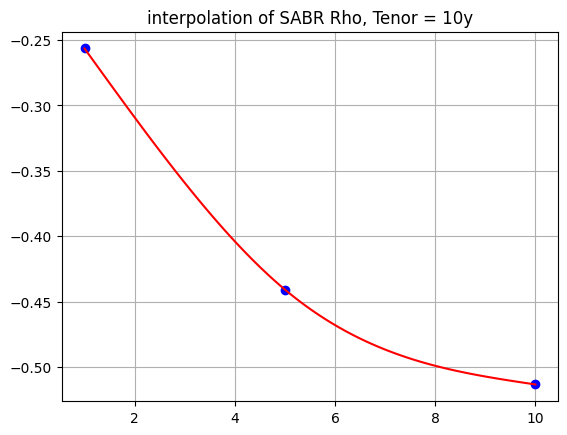

In [7]:
print(df_rho)
plt.plot(df_alpha.index,df_rho[10],"ob")
plt.plot(x_range, [ParameterInterp(x, 10, df_rho) for x in x_range],'-r')
plt.title("interpolation of SABR Rho, Tenor = 10y")
plt.grid()
plt.show()

   Unnamed: 0         1         2         3         5        10
1          1Y  2.049486  1.677386  1.438137  1.064877  0.781464
5          5Y  1.339590  1.061907  0.936714  0.671422  0.494049
10        10Y  1.006550  0.925535  0.868939  0.720157  0.577509


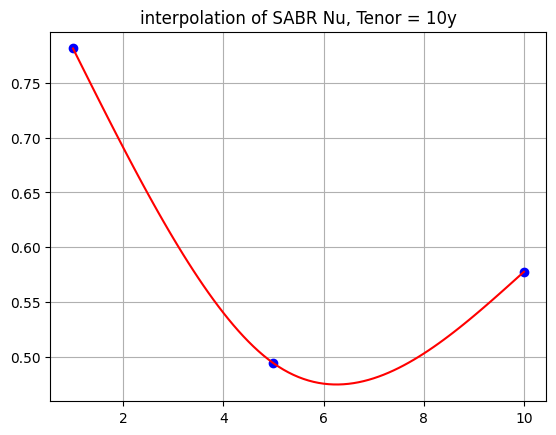

In [8]:
print(df_nu)
plt.plot(df_alpha.index,df_nu[10],"ob")
plt.plot(x_range, [ParameterInterp(x, 10, df_nu) for x in x_range],'-r')
plt.title("interpolation of SABR Nu, Tenor = 10y")
plt.grid()
plt.show()

   Unnamed: 0         1         2         3         5        10
1          1Y  0.139070  0.184651  0.196851  0.178052  0.170749
5          5Y  0.166527  0.199497  0.210348  0.191091  0.177421
10        10Y  0.177383  0.195282  0.207103  0.201575  0.181396


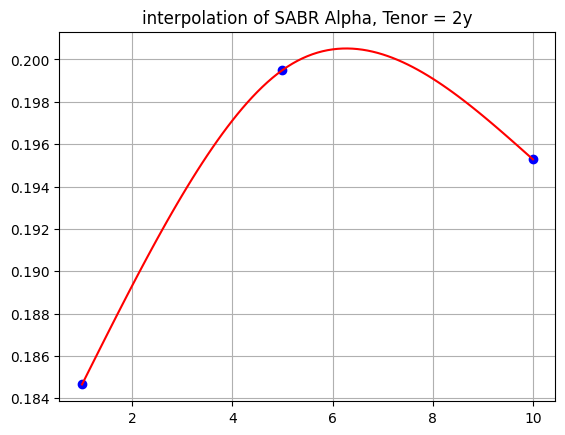

In [9]:
print(df_alpha)
plt.plot(df_alpha.index,df_alpha[2],"ob")
plt.plot(x_range, [ParameterInterp(x, 2, df_alpha) for x in x_range],'-r')
plt.title("interpolation of SABR Alpha, Tenor = 2y")
plt.grid()
plt.show()

   Unnamed: 0         1         2         3         5        10
1          1Y -0.633224 -0.525113 -0.482846 -0.414426 -0.256539
5          5Y -0.585127 -0.546873 -0.549775 -0.511469 -0.440661
10        10Y -0.545252 -0.544508 -0.550637 -0.562735 -0.513125


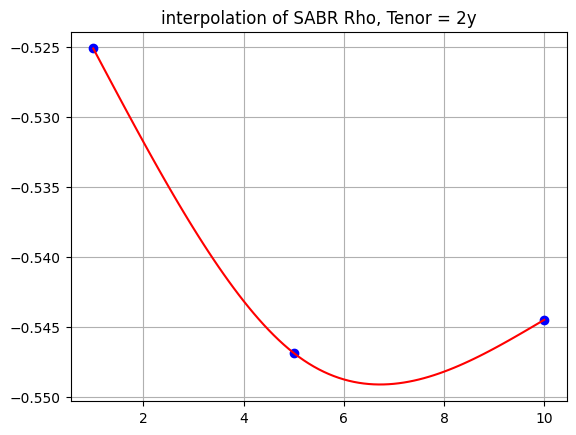

In [10]:
print(df_rho)
plt.plot(df_alpha.index,df_rho[2],"ob")
plt.plot(x_range, [ParameterInterp(x, 2, df_rho) for x in x_range],'-r')
plt.title("interpolation of SABR Rho, Tenor = 2y")
plt.grid()
plt.show()

   Unnamed: 0         1         2         3         5        10
1          1Y  2.049486  1.677386  1.438137  1.064877  0.781464
5          5Y  1.339590  1.061907  0.936714  0.671422  0.494049
10        10Y  1.006550  0.925535  0.868939  0.720157  0.577509


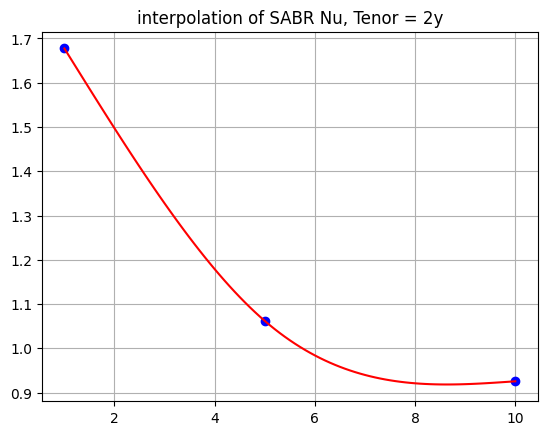

In [11]:
print(df_nu)
plt.plot(df_alpha.index,df_nu[2],"ob")
plt.plot(x_range, [ParameterInterp(x, 2, df_nu) for x in x_range],'-r')
plt.title("interpolation of SABR Nu, Tenor = 2y")
plt.grid()
plt.show()

In [12]:
cms_period = 5
tenor = 10
delta = 0.5

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS10y semi-annually over the next 5 years = ',PV )

PV of a leg receiving CMS10y semi-annually over the next 5 years =  0.20209422381127878


In [13]:
cms_period = 10
tenor = 2
delta = 0.25

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS2y quarterly over the next 10 years = ',PV )

PV of a leg receiving CMS2y quarterly over the next 10 years =  0.3810636898470458


## Question 2: 
### Compare the forward swap rates with the CMS rate

In [14]:
#calculate CMS rates
Exipry = [1, 5, 10]
Tenor = [1, 2, 3, 5, 10]
delta = 0.5

CMS_list = []
for i in Exipry:
    for j in Tenor:
        CMS_list.append(CMS(i,j,delta))
        
Index = ['1 x 1', '1 x 2', '1 x 3', '1 x 5', '1 x 10',
         '5 x 1', '5 x 2', '5 x 3', '5 x 5', '5 x 10',
         '10 x 1', '10 x 2', '10 x 3', '10 x 5', '10 x 10']

In [15]:
df_FS = pd.read_csv('forward_swap.csv')
df_CMS = pd.DataFrame({'CMS_rate':CMS_list}, index = Index)
df_CMS.insert(1,'Forward_Swap_rate', df_FS["Par_Swap_Rate"].values)
df_CMS

,CMS_rate,Forward_Swap_rate
1 x 1,0.032120,0.032007
1 x 2,0.033382,0.033259
1 x 3,0.034120,0.034011
1 x 5,0.035326,0.035255
1 x 10,0.038496,0.038428
5 x 1,0.040129,0.039274
5 x 2,0.040756,0.040075
5 x 3,0.040664,0.040072
5 x 5,0.041532,0.041093
5 x 10,0.044050,0.043634


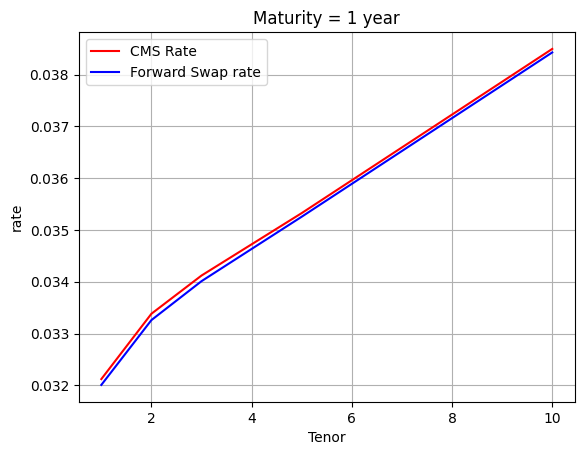

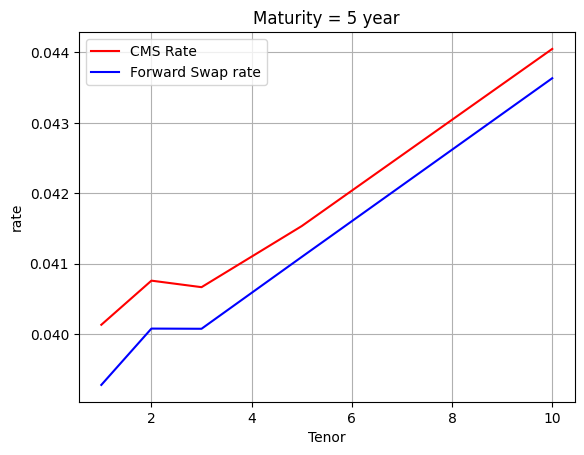

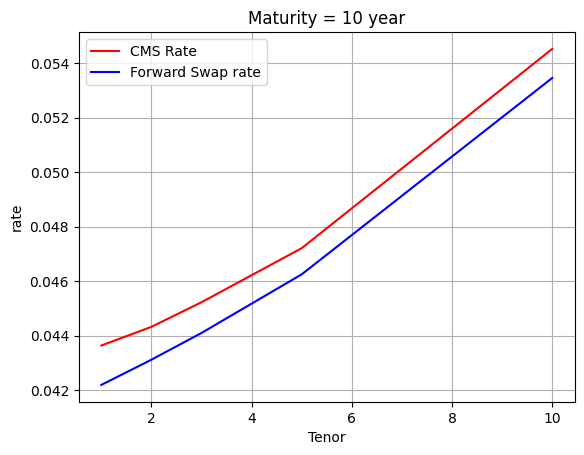

In [16]:
title = ['Maturity = 1 year', 'Maturity = 5 year', 'Maturity = 10 year']
for i in range(3):
    plt.plot(Tenor,df_CMS["CMS_rate"][i*5:(i+1)*5],'-r',label="CMS Rate")
    plt.plot(Tenor,df_CMS["Forward_Swap_rate"][i*5:(i+1)*5],'-b',label="Forward Swap rate")
    plt.title(title[i])
    plt.ylabel("rate")
    plt.xlabel("Tenor")
    plt.legend()
    plt.grid()
    plt.show()